In [11]:
# Import modules
# Carson Batchelor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.formula.api import ols

In [3]:
df = pd.read_csv("RatingData.csv")

df.head()

,id,month,rating,treat
0,75,4,5,0
1,75,6,5,1
2,75,6,4,0
3,75,10,4,0
4,75,10,5,0


In [4]:
# Simple DID model

# Create pre/post and interaction variables
df['post'] = (df['month'] >= 13).astype(int)  # 1 for post-treatment (After Jan 2009)
df['interaction'] = df['treat'] * df['post']

# Summary statistics od the different situations
summary_stats = df.groupby(['treat', 'post'])['rating'].mean().reset_index()
print(summary_stats)

   treat  post    rating
0      0     0  3.713904
1      0     1  3.677605
2      1     0  3.886826
3      1     1  3.945455


In [5]:
# Difference-in-Differences regression
model = smf.ols("rating ~ treat + post + interaction", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     97.73
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           5.15e-63
Time:                        19:06:40   Log-Likelihood:                -56583.
No. Observations:               38004   AIC:                         1.132e+05
Df Residuals:                   38000   BIC:                         1.132e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.7139      0.010    354.604      

The change in TripAdvisor's rating system increased overall ratings by approximately 0.0949 points

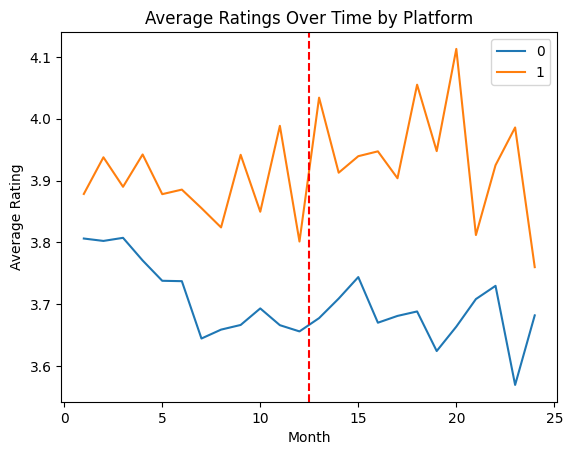

In [6]:
# Average rating trends over time
avg_ratings = df.groupby(['month', 'treat'])['rating'].mean().reset_index()

sns.lineplot(data=avg_ratings, x='month', y='rating', hue='treat')
plt.axvline(x=12.5, color='red', linestyle='--')
plt.title('Average Ratings Over Time by Platform')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

In [7]:
# Get coefficient and standard error for the interaction term
conf_int = model.conf_int().loc['interaction']

# Print uncertainty measures
print(f"Estimated Effect: {model.params['interaction']}")
print(f"Standard Error: {model.bse['interaction']}")
print(f"p-value: {model.pvalues['interaction']}")

print(f"95% Confidence Interval: [{conf_int[0]}, {conf_int[1]}]")

Estimated Effect: 0.09492856458481791
Standard Error: 0.027084164970943417
p-value: 0.0004572237392568942
95% Confidence Interval: [0.041842885822082336, 0.14801424334755348]


## Assumptions:
1. Parallel Trends Assumption
  - In absence of treatment, the trents in overal rating for yelp and TripAdvisor are parallel over time
  - These assumption is valid because of a visual inspection of the pretreatment trends being parallel.
2. Integrity of Data Assumption
  - The composition of reviewer information such as the demographics and preferences does not systematically change between the pre and post treatment periods
  - This could be valid by analyzing reviews and hotel characteristics across both platforms over time
3. No spillover effect
  - The change in tripadvisor rating system did not influence the yelp ratings
  - To validate this we would have to analyze the yelp rating trend seperatly to make sure that there isnt a clear shift when the treatment happens.

## Colleague Approach
- Looking sololy at how ratings change before or after the system change without accounting for a control group could be misleading because of confounding factors and the lack of data
- There are several confounding factors that could effect the rating system beside the treatment such as seasonal trends, the state of the economy, and changes in review behavior. Without a control group, it is very difficult to isolate the effect to just show the treatment
- The results could be biases from pre-existing trends where the trend after the treatment could simply continue from the pre treatment time.

In [15]:
data = pd.read_csv("tips.csv")

data.head()

,fare,tip,ride_duration,distance,passenger_count,day
0,2.9,0.25,2,0.25,1,2
1,2.9,1.00,2,0.28,5,6
2,2.9,1.00,2,0.28,1,3
3,2.9,0.50,1,0.29,1,6
4,2.9,0.50,2,0.16,1,5


                            OLS Regression Results                            
Dep. Variable:            tip_percent   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     140.5
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           1.22e-33
Time:                        19:27:45   Log-Likelihood:                -199.49
No. Observations:                  93   AIC:                             407.0
Df Residuals:                      89   BIC:                             417.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.7410 

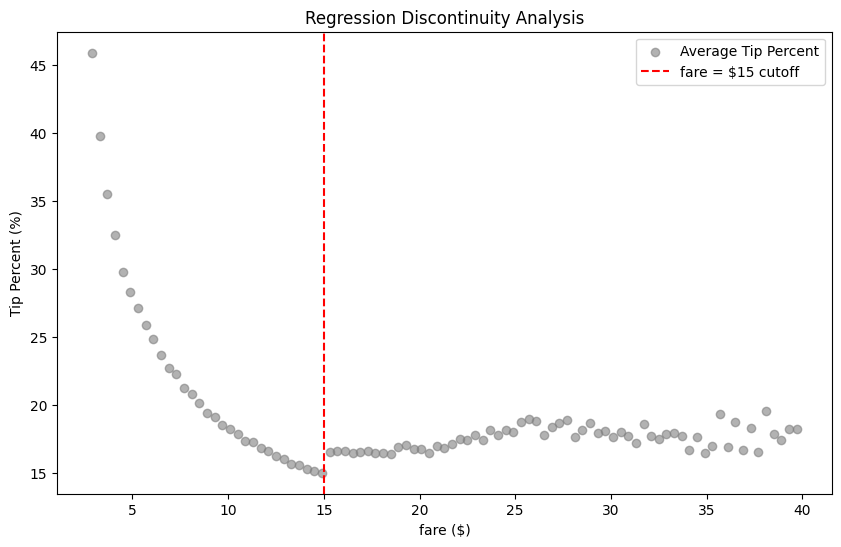

In [20]:
# Create new columns
data['tip_percent'] = (data['tip'] / data['fare']) * 100
data['treat'] = (data['fare'] >= 15).astype(int)
data['distance_from_cutoff'] = data['fare'] - 15
data['interaction'] = data['treat'] * data['distance_from_cutoff']

# Aggregate data by fare
agg_data = data.groupby('fare').mean().reset_index()

# Regression analysis
formula = "tip_percent ~ distance_from_cutoff + treat + interaction"
model = ols(formula=formula, data=agg_data).fit()

# Output RDD estimate
print(model.summary())

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(agg_data['fare'], agg_data['tip_percent'], alpha=0.6, color='gray', label='Average Tip Percent')
plt.axvline(x=15, color='red', linestyle='--', label='fare = $15 cutoff')
plt.xlabel('fare ($)')
plt.ylabel('Tip Percent (%)')
plt.title('Regression Discontinuity Analysis')
plt.legend()
plt.show()


## Key Assumptions:
Continuity Assumption:
 - The relationship between the running variable (fare) and outcome (tip percent) would be smooth in the absence of treatment.
 - Example: If drivers manipulate fares to just exceed $15, the assumption is violated.

Random Assignment Near the Cutoff:
 - The treatment is as good as randomly assigned near $15.
 - Example: if rides differ significantly (Shorter trips below 15 dollars and longer trips above), the assumption is violated

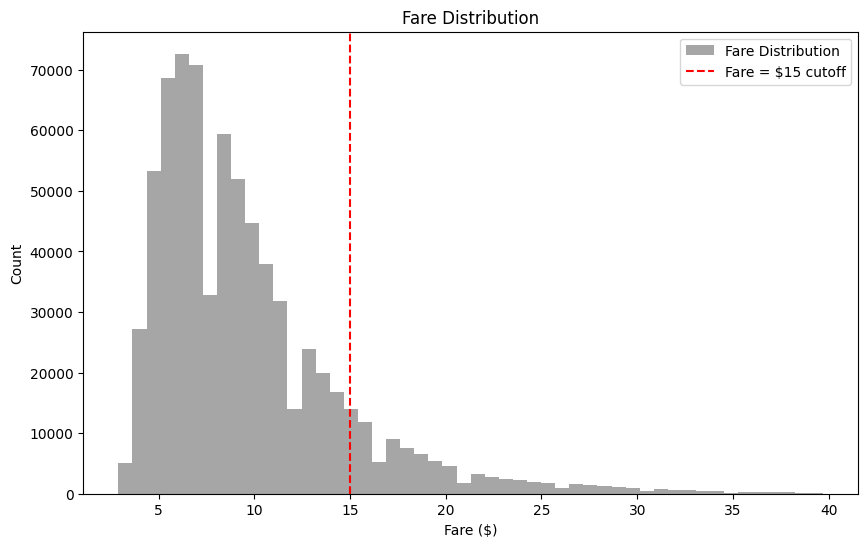

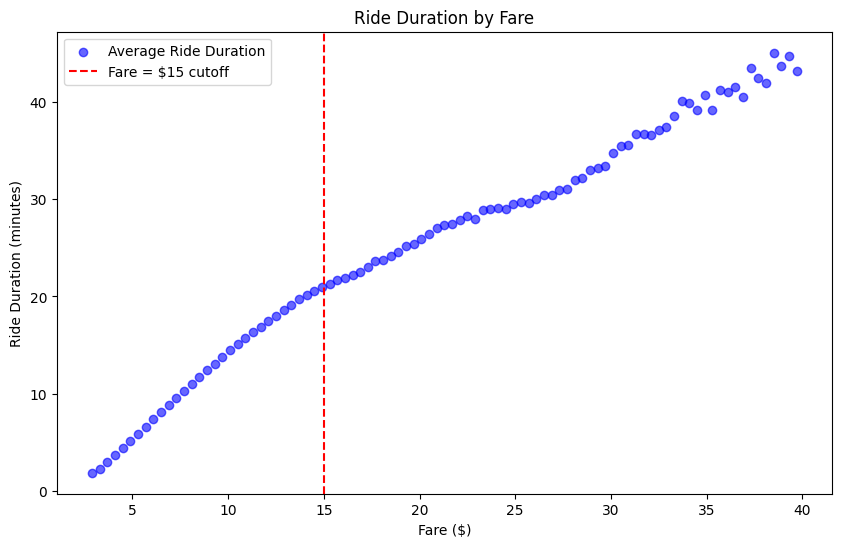

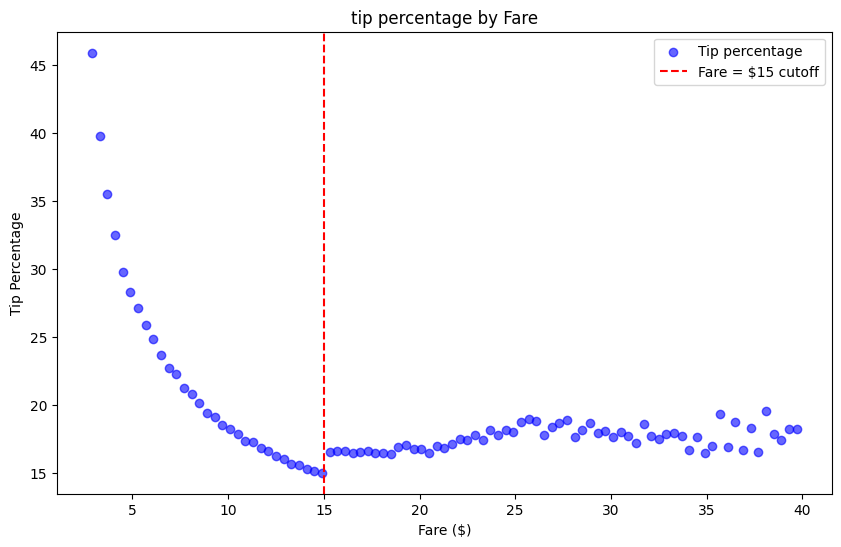

In [27]:
# Fare distribution
plt.figure(figsize=(10, 6))
plt.hist(data['fare'], bins=50, color='gray', alpha=0.7, label='Fare Distribution')
plt.axvline(x=15, color='red', linestyle='--', label='Fare = $15 cutoff')
plt.xlabel('Fare ($)')
plt.ylabel('Count')
plt.title('Fare Distribution')
plt.legend()
plt.show()

# Covariate balance: Ride Duration
plt.figure(figsize=(10, 6))
plt.scatter(agg_data['fare'], agg_data['ride_duration'], alpha=0.6, color='blue', label='Average Ride Duration')
plt.axvline(x=15, color='red', linestyle='--', label='Fare = $15 cutoff')
plt.xlabel('Fare ($)')
plt.ylabel('Ride Duration (minutes)')
plt.title('Ride Duration by Fare')
plt.legend()
plt.show()


# Covariate balance: Ride Duration
plt.figure(figsize=(10, 6))
plt.scatter(agg_data['fare'], agg_data['tip_percent'], alpha=0.6, color='blue', label='Tip percentage')
plt.axvline(x=15, color='red', linestyle='--', label='Fare = $15 cutoff')
plt.xlabel('Fare ($)')
plt.ylabel('Tip Percentage')
plt.title('tip percentage by Fare')
plt.legend()
plt.show()

- Visualize Fare Distribution:
  - This is a histogram of the distribution of fare and there is a clear difference between the distribution under the 15 dollar threshold and above it. This is helpful because it helps us understand deeper the quantity of fare amounts.

-  Plot Covariates by Fare:
 - Plotted ride duration and distance against fare to check for balance near $15.
 - It appears that there is continuity in the ride duration and there is no clear effect on ride duraction that was cause by the fare treatment.

- Check Tip Discontinuity:
 - Plotted the relationship between fare and tip percent, confirming a visible jump at $15.
 - This is helpful because we can visually see that there is a discontinutity meaning that the treatment has an effect.

 # Recommendation

 Based on RDD results:

 - because percentage-based defaults lead to a higher average tip, I would recommend continuing this structure for fares above $15. I know this because the coefficient for the treatment variable in the regression test was positive.

 - Coffee shop tipping is often on smaller transaction amounts. Because of this, I believe that Dollar-based defaults (e.g., $1, $2, $3) may yield better results by anchoring customer choices. I think that this decision will simplify decision-making, and increases the likelihood of higher tips.